In [1]:
# From: https://www.kaggle.com/c/dog-breed-identification/data

from __future__ import print_function, division

import os, sys
import argparse
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import pandas as pd
from pandas import Series, DataFrame

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms, utils

from configs.config_train import get_cfg_defaults

In [2]:
DataPath = r'D:\GitWork\dog_breed\data'
print('Data path: ', DataPath)

RawPath = r'D:\GitWork\dog_breed\data\raw'
print('Raw path: ', RawPath)

label_abspath = os.path.join(RawPath, 'labels.csv')
df = pd.read_csv(label_abspath)

columns = list(df.columns)
print('\nColumns: ', columns)
print()

print(df.info());print()
print(df.head())

Data path:  D:\GitWork\dog_breed\data
Raw path:  D:\GitWork\dog_breed\data\raw

Columns:  ['id', 'breed']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB
None

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [3]:
# Create train ids and valid ids

frac_for_train = 0.8

id_sers = Series.to_numpy(df["id"])
id_sers_num = id_sers.shape[0]
print('Num id series: ', id_sers_num)

train_num = int(float(id_sers_num) * float(frac_for_train))
valid_num = id_sers_num - train_num
print('\nNum for train: ', train_num)
print('Num for valid: ', valid_num)

train_ids = id_sers[:train_num]
valid_ids = id_sers[train_num:]
print('\nTrain ids:'); print('\n'.join(train_ids[:10]))

Num id series:  10222

Num for train:  8177
Num for valid:  2045

Train ids:
000bec180eb18c7604dcecc8fe0dba07
001513dfcb2ffafc82cccf4d8bbaba97
001cdf01b096e06d78e9e5112d419397
00214f311d5d2247d5dfe4fe24b2303d
0021f9ceb3235effd7fcde7f7538ed62
002211c81b498ef88e1b40b9abf84e1d
00290d3e1fdd27226ba27a8ce248ce85
002a283a315af96eaea0e28e7163b21b
003df8b8a8b05244b1d920bb6cf451f9
0042188c895a2f14ef64a918ed9c7b64


In [4]:
def isRawImgExist(p, d, e='.jpg'):
    return (lambda f: os.path.join(*[p, d, f+e]) \
    if os.path.exists(os.path.join(*[p, d, f+e])) else None)

irie = isRawImgExist(RawPath, 'train')
# print(irie('000bec180eb18c7604dcecc8fe0dba07'))

train_imgs = [irie(v) for v in train_ids]
valid_imgs = [irie(v) for v in valid_ids]
print('train image len: ', len(train_imgs))
print('valid image len: ', len(valid_imgs))

print('\nVerify train image exist:')
print('\n'.join(train_imgs[:10]))

print('\nVerify valid image exist:')
print('\n'.join(valid_imgs[:10]))

train_none_nums = sum(x is None for x in train_imgs)
valid_none_nums = sum(x is None for x in valid_imgs)
print('\nTrain None nums: ', train_none_nums)
print('Train None nums: ', valid_none_nums)


train image len:  8177
valid image len:  2045

Verify train image exist:
D:\GitWork\dog_breed\data\raw\train\000bec180eb18c7604dcecc8fe0dba07.jpg
D:\GitWork\dog_breed\data\raw\train\001513dfcb2ffafc82cccf4d8bbaba97.jpg
D:\GitWork\dog_breed\data\raw\train\001cdf01b096e06d78e9e5112d419397.jpg
D:\GitWork\dog_breed\data\raw\train\00214f311d5d2247d5dfe4fe24b2303d.jpg
D:\GitWork\dog_breed\data\raw\train\0021f9ceb3235effd7fcde7f7538ed62.jpg
D:\GitWork\dog_breed\data\raw\train\002211c81b498ef88e1b40b9abf84e1d.jpg
D:\GitWork\dog_breed\data\raw\train\00290d3e1fdd27226ba27a8ce248ce85.jpg
D:\GitWork\dog_breed\data\raw\train\002a283a315af96eaea0e28e7163b21b.jpg
D:\GitWork\dog_breed\data\raw\train\003df8b8a8b05244b1d920bb6cf451f9.jpg
D:\GitWork\dog_breed\data\raw\train\0042188c895a2f14ef64a918ed9c7b64.jpg

Verify valid image exist:
D:\GitWork\dog_breed\data\raw\train\cc93915e06bc55626a02af95006a48c2.jpg
D:\GitWork\dog_breed\data\raw\train\cc964d3bf1e317c9fbb0c0d4c8bc6b8f.jpg
D:\GitWork\dog_breed\dat

In [5]:
ProcPath = r'D:\GitWork\dog_breed\data\processed'

def createNpyFiles(outPath, trainData, validData, datatype='ids'):
    if not datatype=='ids' and not datatype=='labels':
        raise TypeError("Datatype must be 'ids' or 'labels'")
        
    phase  = ['train', 'valid']
    fnames = ['%s_%s.npy'%(x, datatype) for x in phase]
    npy_files  = [os.path.join(outPath, f) for f in fnames]
   
    for f in npy_files:
        tmpstr = '' if os.path.exists(f) else 'not '
        outstr = "'{}' {}exist".format(f, tmpstr)
        print(outstr)
    
    isAllExist = all([os.path.exists(f) for f in npy_files])
    if not isAllExist:
        print("\nProcessing npy files...")
        np.save(npy_files[0], trainData)
        np.save(npy_files[1], validData)
        print('Processed.')
    
    return
    
npy_files = createNpyFiles(ProcPath, train_imgs, valid_imgs)


'D:\GitWork\dog_breed\data\processed\train_ids.npy' exist
'D:\GitWork\dog_breed\data\processed\valid_ids.npy' exist


In [6]:
# 建立品種名稱與編號的對應字典

breed_sers = Series.to_numpy(df['breed'])
breed_sers_num = breed_sers.shape[0]
print('Breed series num: ', breed_sers_num)
    
# 整理有多少種品種
breed_set = set(breed_sers)
breed_set_len = len(breed_set)
print('Breed set size: ', breed_set_len)

# 建構一個品種名稱與編號的對應字典
breed_list = list(breed_set)
breed_list.sort()
breed_dict_fw  = { v:i for i, v in enumerate(breed_list) }
breed_dict_bw = { i:v for i, v in enumerate(breed_list) }
breed_dict_len = len(breed_dict_fw)

print('\nBreed dict len: ', breed_dict_len)
print(json.dumps(breed_dict_fw, indent=4))

Breed series num:  10222
Breed set size:  120

Breed dict len:  120
{
    "affenpinscher": 0,
    "afghan_hound": 1,
    "african_hunting_dog": 2,
    "airedale": 3,
    "american_staffordshire_terrier": 4,
    "appenzeller": 5,
    "australian_terrier": 6,
    "basenji": 7,
    "basset": 8,
    "beagle": 9,
    "bedlington_terrier": 10,
    "bernese_mountain_dog": 11,
    "black-and-tan_coonhound": 12,
    "blenheim_spaniel": 13,
    "bloodhound": 14,
    "bluetick": 15,
    "border_collie": 16,
    "border_terrier": 17,
    "borzoi": 18,
    "boston_bull": 19,
    "bouvier_des_flandres": 20,
    "boxer": 21,
    "brabancon_griffon": 22,
    "briard": 23,
    "brittany_spaniel": 24,
    "bull_mastiff": 25,
    "cairn": 26,
    "cardigan": 27,
    "chesapeake_bay_retriever": 28,
    "chihuahua": 29,
    "chow": 30,
    "clumber": 31,
    "cocker_spaniel": 32,
    "collie": 33,
    "curly-coated_retriever": 34,
    "dandie_dinmont": 35,
    "dhole": 36,
    "dingo": 37,
    "doberman": 

In [7]:
# 將 label.csv 中所有的品種類別轉換成品種編號

train_bids = [breed_dict_fw[df.loc[df['id']==i].breed.item()] for i in train_ids]
valid_bids = [breed_dict_fw[df.loc[df['id']==i].breed.item()] for i in valid_ids]

def showBreedIds(ids, num=10):
    sample = ids[:num]
    breeds = [df.loc[df['id']==i].breed.item() for i in sample]
    bids = [breed_dict_fw[i] for i in breeds]
    
    col_width = max(len(i) for i in breeds)
    print('id,breed,breed_id')
    for i in range(len(sample)):
        v = sample[i]
        breed = "".join(breeds[i].ljust(col_width))
        print('{}, {}, {}'.format(v, breed, bids[i]))
    return
        
showBreedIds(train_ids, num=10)
print(); print(train_bids[:10])

# print()
# showBreedIds(valid_ids, num=10)
# print(); print(valid_bids[:10])

id,breed,breed_id
000bec180eb18c7604dcecc8fe0dba07, boston_bull       , 19
001513dfcb2ffafc82cccf4d8bbaba97, dingo             , 37
001cdf01b096e06d78e9e5112d419397, pekinese          , 85
00214f311d5d2247d5dfe4fe24b2303d, bluetick          , 15
0021f9ceb3235effd7fcde7f7538ed62, golden_retriever  , 49
002211c81b498ef88e1b40b9abf84e1d, bedlington_terrier, 10
00290d3e1fdd27226ba27a8ce248ce85, bedlington_terrier, 10
002a283a315af96eaea0e28e7163b21b, borzoi            , 18
003df8b8a8b05244b1d920bb6cf451f9, basenji           , 7
0042188c895a2f14ef64a918ed9c7b64, scottish_deerhound, 97

[19, 37, 85, 15, 49, 10, 10, 18, 7, 97]


In [8]:
# Save labels as file

fname_list = ['{}_labels.npy'.format(x) for x in ['train', 'valid']]

npy_list = [os.path.join(ProcPath, x) for x in fname_list]

isAllExist = all([os.path.exists(f) for f in npy_list])

if not isAllExist:
    print("\n'*_label.npy' files not exist, processing...")
    np.save(npy_files[0], train_bids)
    np.save(npy_files[0], valid_bids)
    print('Processed')
else:
    print("\n*_labels.npy' alrady exist.")


*_labels.npy' alrady exist.


In [9]:
# Create Dataset

# Normalize
normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std  = [0.229, 0.224, 0.225]
)

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])


def default_loader(imgPath, fname):
    img_pil = Image.open(os.path.join(imgPath, fname))
    img_pil = img_pil.resize((224,224))
    return img_pil


class myDataset(Dataset):
    
    def __init__(self, path, phase='train', transform=None):
        img_files = os.path.join(path, '{}_ids.npy'.format(phase))
        lbl_files = os.path.join(path, '{}_labels.npy'.format(phase))
        
        self.images = np.load(img_files)
        self.labels = np.load(lbl_files)
        
        self.transform = transform
        self.len = len(self.images)

    def __getitem__(self, index):
        img_file = self.images[index]
        
        img = Image.open(img_file)
        img = img.resize((224,224))

        if self.transform is not None:
            img = self.transform(img)
            
        lbl = self.labels[index]
        
        return img, lbl

    def __len__(self):
        return self.len
    
trainSet = myDataset(ProcPath, transform=transform)
validSet = myDataset(ProcPath, phase='valid', transform=transform)
print('TrainSet size: ', len(trainSet))
print('ValidSet size: ', len(validSet))

trainLoader = DataLoader(trainSet, batch_size=100, shuffle=True)
validLoader = DataLoader(validSet, batch_size=100, shuffle=False)
print('\nTrainLoader size: ', len(trainLoader))
print('ValidLoader size: ', len(validLoader))

images, labels = next(iter(trainLoader))

print('\nImage type: ', type(images))
print('Label type: ', type(labels))

print('\nImage size: ', images.size())
print('Label size: ', labels.size())

image = images[0]
print('\nImage: ', image.shape)
print(); print(image)

label = labels[0]
print('\nLabel: ', label)

TrainSet size:  8177
ValidSet size:  2045

TrainLoader size:  82
ValidLoader size:  21

Image type:  <class 'torch.Tensor'>
Label type:  <class 'torch.Tensor'>

Image size:  torch.Size([100, 3, 224, 224])
Label size:  torch.Size([100])

Image:  torch.Size([3, 224, 224])

tensor([[[0.9132, 1.0844, 0.8104,  ..., 0.9988, 1.1700, 1.0673],
         [0.6392, 0.7762, 0.7248,  ..., 1.1187, 1.2728, 1.1187],
         [0.4679, 0.4851, 1.2385,  ..., 1.0159, 1.1872, 1.2043],
         ...,
         [1.0159, 1.0673, 1.0159,  ..., 1.0331, 1.0502, 1.0673],
         [0.9303, 0.9817, 0.9646,  ..., 0.9988, 0.9988, 0.9988],
         [0.9474, 0.9988, 0.9646,  ..., 0.9646, 0.9646, 0.9474]],

        [[1.3782, 1.4832, 1.1155,  ..., 1.2731, 1.4482, 1.3431],
         [1.0980, 1.1681, 1.0630,  ..., 1.4132, 1.5532, 1.3957],
         [0.9230, 0.8880, 1.5882,  ..., 1.2906, 1.4657, 1.4832],
         ...,
         [1.3431, 1.3957, 1.3431,  ..., 1.3081, 1.3081, 1.3256],
         [1.2556, 1.3081, 1.2906,  ..., 1.2556, 

train images shape:  torch.Size([6, 3, 224, 224])
train labels shape:  torch.Size([6])


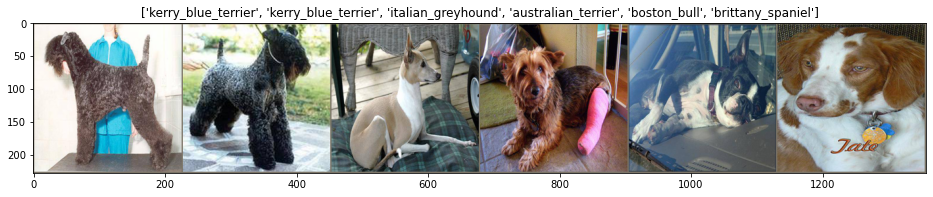

In [11]:
# Imshow for Tensor
def imshow(inp, title=None):
    inp  = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.figure(figsize=(16,16))
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    return

sampleLoader = DataLoader(trainSet, batch_size=6, shuffle=True)    

# Get a batch of training data
images, labels = next(iter(sampleLoader))
print('train images shape: ', images.shape)
print('train labels shape: ', labels.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(images)

imshow(out, title=[breed_dict_bw.get(x.item()) for x in labels])